In [1]:
import os
import io
import imageio
import ipywidgets
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from nebula.common import to_scale_one, write_pickle, read_pickle, display, display_color
from nebula.data.yg_ar.setup_data_image_hard import split_ar_anim_df

2023-04-20 23:23:45.608557: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 23:23:45.610474: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 23:23:45.645849: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 23:23:45.646691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 23:23:46.163903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
v5f_pickle_path = '/home/ubuntu/data/yg_ar/v5f_hard_df.pkl'
save_model_path = './transformer_hard_action_only.h5'

In [3]:
# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

In [24]:
# DATA
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (5, 156, 156, 1)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 60

# TUBELET EMBEDDING
PATCH_SIZE = (2, 16, 16)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

In [25]:
def create_label_map(labels):
    label_set = set()
    for lt in labels:
        label_set.add(lt)
        
    label_set = list(label_set)
    label_set.sort()

    label_map = {}
    count = 0
    for l in label_set:
        label_map[l] = count
        count += 1
        
    return label_map

In [26]:
df = read_pickle(v5f_pickle_path)

In [27]:
random_seed = 1
train_df, test_df, valid_df = split_ar_anim_df(df, random_seed)
train_df = train_df.sample(frac=1, random_state=random_seed)  # randomize train_df

In [28]:
label_map_a = create_label_map(df["label_a"])
label_map_at = create_label_map(df["label_at"])

In [29]:
train_videos = np.array(train_df["images"].to_list())

In [30]:
train_labels = train_df["label_a"].map(label_map_a).to_list()
# train_labels = train_df["label_at"].map(label_map_at).to_list()

In [31]:
valid_videos = np.array(valid_df["images"].to_list())
valid_labels = valid_df["label_a"].map(label_map_a).to_list()
# valid_labels = valid_df["label_at"].map(label_map_at).to_list()

In [32]:
test_videos = np.array(test_df["images"].to_list())
test_labels = test_df["label_a"].map(label_map_a).to_list()
# test_labels = test_df["label_at"].map(label_map_at).to_list()

In [33]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [34]:
train_videos.shape

(16080, 5, 156, 156)

In [35]:
train_videos[0][0,:,:].shape

(156, 156)

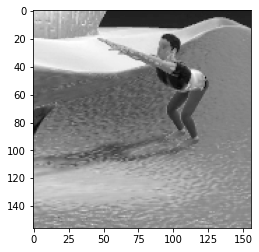

In [36]:
plt.imshow(train_videos[0][2,:,:], cmap=plt.cm.gray)

In [37]:
@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare the dataloader."""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return dataloader


trainloader = prepare_dataloader(train_videos, train_labels, "train")
validloader = prepare_dataloader(valid_videos, valid_labels, "valid")
testloader = prepare_dataloader(test_videos, test_labels, "test")

In [38]:
class TubletProjection(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )

    def call(self, videos):
        projected_patches = self.projection(videos)
        return projected_patches

class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, projected_patches):
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

In [39]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [40]:
def create_vivit_classifier(
    tubelet_projector,
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    projected_patches = tubelet_projector(inputs)
    patches = tubelet_embedder(projected_patches)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [41]:
model = create_vivit_classifier(
        tubelet_projector = TubletProjection(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        tubelet_embedder=TubeletEmbedding(embed_dim=PROJECTION_DIM),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

In [42]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 156, 156  0           []                               
                                , 1)]                                                             
                                                                                                  
 tublet_projection_1 (TubletPro  (None, 2, 9, 9, 128  65664      ['input_2[0][0]']                
 jection)                       )                                                                 
                                                                                                  
 tubelet_embedding_1 (TubeletEm  (None, 162, 128)    0           ['tublet_projection_1[0][0]']    
 bedding)                                                                                   

In [43]:
def run_experiment(model):
    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Train the model.
    _ = model.fit(trainloader, epochs=EPOCHS, validation_data=validloader)

    _, accuracy, top_5_accuracy = model.evaluate(testloader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model


model = run_experiment(model)

Epoch 1/60


2023-04-20 23:24:42.409613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [16080,5,156,156]
	 [[{{node Placeholder/_0}}]]
2023-04-20 23:24:42.409879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [16080,5,156,156]
	 [[{{node Placeholder/_0}}]]


2010/2010 [==============================] - ETA: 0s - loss: 2.3436 - accuracy: 0.0973 - top-5-accuracy: 0.4947

2023-04-20 23:30:55.232567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1760]
	 [[{{node Placeholder/_1}}]]
2023-04-20 23:30:55.232818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1760]
	 [[{{node Placeholder/_1}}]]


2010/2010 [==============================] - 387s 188ms/step - loss: 2.3436 - accuracy: 0.0973 - top-5-accuracy: 0.4947 - val_loss: 2.3123 - val_accuracy: 0.1000 - val_top-5-accuracy: 0.5000
Epoch 2/60
2010/2010 [==============================] - 378s 188ms/step - loss: 2.3199 - accuracy: 0.0984 - top-5-accuracy: 0.4935 - val_loss: 2.3119 - val_accuracy: 0.1006 - val_top-5-accuracy: 0.5000
Epoch 3/60
2010/2010 [==============================] - 377s 187ms/step - loss: 2.3152 - accuracy: 0.1006 - top-5-accuracy: 0.4902 - val_loss: 2.3093 - val_accuracy: 0.1011 - val_top-5-accuracy: 0.5000
Epoch 4/60
2010/2010 [==============================] - 377s 187ms/step - loss: 2.3112 - accuracy: 0.0997 - top-5-accuracy: 0.4978 - val_loss: 2.3053 - val_accuracy: 0.1176 - val_top-5-accuracy: 0.5091
Epoch 5/60
2010/2010 [==============================] - 377s 187ms/step - loss: 2.2207 - accuracy: 0.1432 - top-5-accuracy: 0.5987 - val_loss: 2.0466 - val_accuracy: 0.1920 - val_top-5-accuracy: 0.7216
E

2023-04-21 05:41:15.113217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [2160]
	 [[{{node Placeholder/_1}}]]
2023-04-21 05:41:15.113447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [2160]
	 [[{{node Placeholder/_1}}]]


270/270 [==============================] - 17s 62ms/step - loss: 0.7721 - accuracy: 0.8292 - top-5-accuracy: 0.9940
Test accuracy: 82.92%
Test top 5 accuracy: 99.4%


In [44]:
model.save(save_model_path)